In [ ]:
# Notebook for training and testing a Player in Pokemon Showdown using Monte Carlo in Deterministic Environment

In [ ]:
"""
Comparative Table: https://prnt.sc/1ytqrzm
------
neptune
Action space: 4 moves + 5 switches
poke-env installed in C:\\Users\\-\\anaconda3\\envs\\poke_env\\lib\\site-packages
"""


In [2]:
# Imports

import numpy as np

import sys
from gym import spaces
import asyncio
import time

from collections import defaultdict

from src.playerMC import Player as PlayerMC

from poke_env.player.player import Player 
from poke_env.player.random_player import RandomPlayer

from poke_env.environment.abstract_battle import AbstractBattle

import matplotlib
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(0)
use_neptune = False
if use_neptune:
    import neptune.new as neptune
    run = neptune.init(project='your_project_here',
                       api_token='your api token here')


In [3]:
# Encoding Pokémon Name for ID

def name_to_id(name):
    if(name == 'turtonator'): return 0
    if(name == 'lapras'): return 1 
    if(name == 'armaldo'): return 2 
    if(name == 'drapion'): return 3 
    if(name == 'kabutops'): return 4 
    if(name == 'falinks'): return 5 
    if(name == 'cloyster'): return 0
    if(name == 'omastar'): return 1 
    if(name == 'crustle'): return 2 
    if(name == 'escavalier'): return 3 
    if(name == 'drednaw'): return 4 
    if(name == 'typenull'): return 5     

In [4]:
# Definition of MaxDamagePlayer

class MaxDamagePlayer(Player):
    def choose_move(self, battle):
        # If the player can attack, it will
        if battle.available_moves:
            # Finds the best move among available ones
            best_move = max(battle.available_moves, key=lambda move: move.base_power)
            return self.create_order(best_move)

        # If no attack is available, a random switch will be made
        else:
            return self.choose_random_move(battle)

In [5]:
# Definition of Monte Carlo Player

class MCPlayer(PlayerMC):
    def choose_move(self, battle):
        # In the 1st state of all we don't append yet;
        # Other states: using previous state and action with actual reward (actual battle) 
        if self.previous_action != -10: self.episode.append((self.previous_state, self.previous_action, self.compute_reward(battle)))
            
        # Getting state s (-> embed battle)
        s = self.embed_battle(battle)
        # 1st move will be random wout policy    
        if(self.aux == 0):
            self.aux = 1
            action = np.random.choice(self.action_space)

        # Other moves have policy    
        else: action = np.random.choice(self.action_space, p=self.policy(s))

        # Saving action and state to append later. We can compute the reward only after the move    
        self.previous_action = action
        self.previous_state = s

        # Choose move according to action index
        if action == -1:
            return ForfeitBattleOrder()
        elif (
            action < 4
            and action < len(battle.available_moves)
            and not battle.force_switch
        ):
            return self.create_order(battle.available_moves[action])
        elif 0 <= action - 4 < len(battle.available_switches):
            return self.create_order(battle.available_switches[action - 4])
        else:
            return self.choose_random_move(battle)
        

    # the embed battle is our state
    # 10 factors: 4 moves base power, 4 moves multipliers, active pokemon and active opponent pokemon 
    def embed_battle(self, battle):
        # -1 indicates that the move does not have a base power or not available
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                move.base_power / 100
            )  # Simple rescaling 
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # how many pokemons have fainted in each team
        remaining_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted]) / 6
        )
        remaining_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted]) / 6
        )

        state = list()       
        state.append('{0:.2f}'.format(name_to_id(str(battle.active_pokemon).split(' ')[0])))
        state.append('{0:.2f}'.format(name_to_id(str(battle.opponent_active_pokemon).split(' ')[0])))    
        for move_base_power in moves_base_power:
            state.append('{0:.2f}'.format(move_base_power))
        for move_dmg_multiplier in moves_dmg_multiplier:
            state.append('{0:.2f}'.format(move_dmg_multiplier))
        state.append('{0:.2f}'.format(remaining_mon_team))
        state.append('{0:.2f}'.format(remaining_mon_opponent))
        # Convert to string so we can use as hash
        return str(state)

        

    # Computing rewards
    def reward_computing_helper(
        self,
        battle: AbstractBattle,
        *,
        fainted_value: float = 0.15, 
        hp_value: float = 0.15,      
        number_of_pokemons: int = 6,
        starting_value: float = 0.0,
        status_value: float = 0.15, 
        victory_value: float = 1.0
    ) -> float:
        
        # 1st compute
        if battle not in self._reward_buffer:
            self._reward_buffer[battle] = starting_value
        current_value = 0
        
        # Verify if pokemon have fainted or have status
        for mon in battle.team.values():
            current_value += mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value -= fainted_value
            elif mon.status is not None:
                current_value -= status_value

        current_value += (number_of_pokemons - len(battle.team)) * hp_value

        # Verify if opponent pokemon have fainted or have status
        for mon in battle.opponent_team.values():
            current_value -= mon.current_hp_fraction * hp_value
            if mon.fainted:
                current_value += fainted_value
            elif mon.status is not None:
                current_value += status_value

        current_value -= (number_of_pokemons - len(battle.opponent_team)) * hp_value

        # Verify if we won or lost
        if battle.won:
            current_value += victory_value
        elif battle.lost:
            current_value -= victory_value

        # Value to return
        to_return = current_value - self._reward_buffer[battle]
        self._reward_buffer[battle] = current_value
        if use_neptune: run[f'N0: {self.n0} gamma: {self.gamma} reward_buffer'].log(current_value)
        return to_return
    
    
    # Calling reward_computing_helper
    def compute_reward(self, battle) -> float:
        return self.reward_computing_helper(            
            battle, fainted_value=2, hp_value=1, status_value=1, victory_value=15
        )

    # Battle (episode) has finished
    def _battle_finished_callback(self, battle):
        rewards = [reward for state,action,reward in self.episode]
        states = [state for state,action,reward in self.episode]
        actions = [action for state,action,reward in self.episode]
        t_array = range(len(self.episode)+1)
        # Computing Q and N
        for idx, state in enumerate(states):
            action = actions[idx]
            if state not in self.visited_states:
                self.N[state][action] += 1
                returnGt = sum([reward*pow(self.gamma, t) for reward, t in zip(rewards[idx:], t_array[:(-idx-1)])]) 

                # incremental update of Q value is more efficient than keeping a record of all rewards
                # and averaging after every new reward
                # step-size: 1./N[state][action]
                
                self.Q[state][action] += (1/self.N[state][action])*(returnGt-self.Q[state][action]) 
                #run[f'N0: {self.n0} gamma: {self.gamma} q_value'].log(self.Q[state][action])
                self.visited_states.append(state)
                
        self.visited_states = []
        self.episode = []
        if(self.aux == 1):
            self.aux == 0
            
        # Define new policy with updated Q and N
        self.policy = self.update_epsilon_greedy_policy(self.Q, self.n0, self.N)
        if use_neptune: run[f'N0: {self.n0} gamma: {self.gamma} win_acc'].log(self.n_won_battles/len(self._reward_buffer))
        

In [6]:
# Definition of the agent team (Pokémon Showdown template)

our_team = """
Turtonator @ White Herb  
Ability: Shell Armor  
EVs: 4 Atk / 252 SpA / 252 Spe  
Rash Nature  
- Flamethrower  
- Dragon Pulse  
- Earthquake  
- Shell Smash  

Lapras @ Leftovers  
Ability: Shell Armor  
EVs: 252 HP / 252 SpA / 4 SpD  
Modest Nature  
IVs: 0 Atk  
- Freeze-Dry  
- Surf  
- Thunderbolt  
- Toxic  

Armaldo @ Assault Vest  
Ability: Battle Armor  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Earthquake  
- Knock Off  
- X-Scissor  
- Aqua Jet  

Drapion @ Life Orb  
Ability: Battle Armor  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Poison Jab  
- Knock Off  
- Earthquake  
- X-Scissor  

Kabutops @ Aguav Berry  
Ability: Battle Armor  
EVs: 252 Atk / 4 SpD / 252 Spe  
Jolly Nature  
- Liquidation  
- Leech Life  
- Knock Off  
- Swords Dance  

Falinks @ Iapapa Berry  
Ability: Battle Armor  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Close Combat  
- Poison Jab  
- Iron Head  
- No Retreat  

"""

In [7]:
# Definition of the opponent team (Pokémon Showdown template)

op_team = """
Cloyster @ Assault Vest  
Ability: Shell Armor  
EVs: 248 HP / 252 Atk / 8 SpA  
Naughty Nature  
- Icicle Spear  
- Surf  
- Tri Attack  
- Poison Jab  

Omastar @ White Herb  
Ability: Shell Armor  
EVs: 252 SpA / 4 SpD / 252 Spe  
Modest Nature  
IVs: 0 Atk  
- Surf  
- Ancient Power  
- Earth Power  
- Shell Smash  

Crustle @ Leftovers  
Ability: Shell Armor  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Earthquake  
- Knock Off  
- X-Scissor  
- Stealth Rock  

Escavalier @ Life Orb  
Ability: Shell Armor  
EVs: 248 HP / 252 Atk / 8 SpD  
Adamant Nature  
- Knock Off  
- Swords Dance  
- Iron Head  
- Poison Jab  

Drednaw @ Aguav Berry  
Ability: Shell Armor  
EVs: 248 HP / 252 Atk / 8 SpD  
Adamant Nature  
- Liquidation  
- Earthquake  
- Poison Jab  
- Swords Dance  

Type: Null @ Eviolite  
Ability: Battle Armor  
EVs: 252 HP / 252 Atk / 4 SpD  
Adamant Nature  
- Facade  
- Knock Off 
- Shadow Claw  
- Rest  

"""

In [8]:
# Global variables

# 3 sets of tests; 10k battles each
n0_array = [0.0001, 0.001, 0.01]
gamma_array = [0.75, 0.75, 0.75] 
n_battles = [10000 for n0 in n0_array] #all tests have 10k battles; Can be modified to different values (must have same shape)
our_team_array = [our_team for n0 in n0_array] #all teams are the same; Can be modified to different teams (must have same shape)
op_team_array = [op_team for n0 in n0_array] #all opponents are the same; Can be modified to different teams (must have same shape)

tests =[ {'n0': n0,
          'gamma': gamma,
          'n_battles':n_battle,
          'team':our_team,
          'against':op_team,
          'battle_format':"gen8ou"}
        for n0,gamma,n_battle,our_team,op_team in zip(n0_array,gamma_array,n_battles,our_team_array,op_team_array)]


In [9]:
len(tests)

3

In [9]:
for test in tests:
    start = time.time()
    if use_neptune: run['params'] = test
    test['opponent'] = MaxDamagePlayer(battle_format="gen8ou", team=test['against'])
    test['player'] = MCPlayer(battle_format="gen8ou", team=test['team'], n0=test['n0'], gamma=test['gamma'])
    await test['player'].battle_against(test['opponent'], n_battles=test['n_battles'])
    
    print(
        "Player with N0=%f and gamma=%f won %d / %d battles [this is %f percent and took %f seconds]"
        % (
            round(test['n0'], 8), 
            round(test['gamma'], 8),
            test['player'].n_won_battles,
            len(test['player']._reward_buffer),
            round(test['player'].n_won_battles/len(test['player']._reward_buffer)*100, 2),
            round(time.time() - start, 2)
        )
    )
    


Player with N0=0.000100 and gamma=0.750000 won 4039 / 10000 battles [this is 40.390000 percent and took 1524.770000 seconds]


Info (NVML): Unknown Error. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


Player with N0=0.001000 and gamma=0.750000 won 3851 / 10000 battles [this is 38.510000 percent and took 1437.560000 seconds]
Player with N0=0.010000 and gamma=0.750000 won 3443 / 10000 battles [this is 34.430000 percent and took 1570.600000 seconds]


In [10]:
if use_neptune: run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 37 operations to synchronize with Neptune. Do not kill this process.


All 37 operations synced, thanks for waiting!


In [1]:
import os
import json
import re
from datetime import date
today = date.today()


In [12]:
# helper function: save to json file
def save_to_json(path, params, name, value):
    today_s = str(date.today())
    n_battle_s = str(params['n_battles'])
    n0_s = str(round(params['n0'], 8))
    gamma_s = str(round(params['gamma'], 8))
    winning_percentage_s = str(round((params['player'].n_won_battles / params['n_battles']) * 100, 2))
    if not os.path.exists(path):
        os.makedirs(path)
    filename = path + "/" + name + "_MCControlDet_" + today_s + "_n_battles_" + n_battle_s + "_N0_" + n0_s + "_gamma_" + gamma_s + "_wining_" + winning_percentage_s
    filename=re.sub(r'(?<=\d)[,\.-]','',filename)+".json"
    file = open(filename, "w")
    value_dict = dict()
    for key in value:
        value_dict[key] = value[key].tolist()
    json.dump(value_dict, file)
    file.close()


In [13]:
# Saving Q and N to json files
for params in tests:
    save_to_json("./dump", params, "Q", params['player'].Q)
    save_to_json("./dump", params, "N", params['player'].N)

In [14]:
# Definition of Monte Carlo validation player

class ValidationPlayer(PlayerMC):
    def __init__(self, battle_format, team, Q, N, n0):
        super().__init__(battle_format=battle_format, team=team)
        self.Q = Q
        self.N = N
        self.n0 = n0
        self.policy = self.update_epsilon_greedy_policy(self.Q, self.n0, self.N)
        
    def choose_move(self, battle):
        state = self.embed_battle(battle)
        # let's get the greedy action. Ties must be broken arbitrarily
        if state in self.Q.keys():
            action = np.random.choice(self.action_space, p=self.policy(state))
        else:
            return self.choose_random_move(battle)

        # if the selected action is not possible, perform a random move instead
        if action == -1:
            return ForfeitBattleOrder()
        elif action < 4 and action < len(battle.available_moves) and not battle.force_switch:
            return self.create_order(battle.available_moves[action])
        elif 0 <= action - 4 < len(battle.available_switches):
            return self.create_order(battle.available_switches[action - 4])
        else:
            return self.choose_random_move(battle)

    def _battle_finished_callback(self, battle):
        pass

    # the embed battle is our state
    # 11 factors: 4 moves base power, 4 moves multipliers, active pokemon and active opponent pokemon 
    def embed_battle(self, battle):
        # -1 indicates that the move does not have a base power or not available

        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                move.base_power / 100
            )  # Simple rescaling 
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # how many pokemons have fainted in each team
        remaining_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted]) / 6
        )
        
        remaining_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted]) / 6
        )
        
        state = list()
        state.append('{0:.2f}'.format(name_to_id(str(battle.active_pokemon).split(' ')[0])))
        state.append('{0:.2f}'.format(name_to_id(str(battle.opponent_active_pokemon).split(' ')[0])))    
        for move_base_power in moves_base_power:
            state.append('{0:.2f}'.format(move_base_power))
        for move_dmg_multiplier in moves_dmg_multiplier:
            state.append('{0:.2f}'.format(move_dmg_multiplier))
        state.append('{0:.2f}'.format(remaining_mon_team))
        state.append('{0:.2f}'.format(remaining_mon_opponent))
        # Convert to string so we can use as hash
        return str(state)

In [15]:
# Get values from json files

Qarray = []
directoryQ = r'path\211104_MCControl_Det\qvalues'
Narray = []
directoryN = r'path\211104_MCControl_Det\nvalues'
for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)
    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
    Qarray.append(Qjson)

for filenameN in os.listdir(directoryN):
    Njson_file = open(directoryN+'/'+filenameN,)
    Njson = json.load(Njson_file)
    for key in Njson:
        Njson[key] = np.array(Njson[key])
    Narray.append(Njson)
    

In [18]:
# Validate with values from json - vs RandomPlayer
for test, qvalue, nvalue in zip(tests, Qarray, Narray):
    start = time.time()
    test['opponent'] = RandomPlayer(battle_format="gen8ou", team=test['against'])
    test['player_val'] = ValidationPlayer(battle_format="gen8ou", team=test['team'], Q=qvalue, N=nvalue, n0=test['n0'])
    await test['player_val'].battle_against(test['opponent'], n_battles=int(test['n_battles']/3))
    
    print(
        "Player with N0=%f and gamma=%f won %d / %d battles [this is %f percent and took %f seconds]"
        % (
            round(test['n0'], 8),
            round(test['gamma'], 8),
            test['player_val'].n_won_battles,
            int(test['n_battles']/3),
            round(test['player_val'].n_won_battles/int(test['n_battles']/3), 2),
            round(time.time() - start, 2)
        )
    )

Player with N0=0.000100 and gamma=0.750000 won 9 / 3333 battles [this is 0.000000 percent and took 4.010000 seconds]
Player with N0=0.001000 and gamma=0.750000 won 9 / 3333 battles [this is 0.000000 percent and took 3.720000 seconds]
Player with N0=0.010000 and gamma=0.750000 won 9 / 3333 battles [this is 0.000000 percent and took 4.160000 seconds]


In [20]:
# Validate with values from json - vs MaxPlayer
for test, qvalue, nvalue in zip(tests, Qarray, Narray):
    start = time.time()
    test['opponent'] = MaxDamagePlayer(battle_format="gen8ou", team=test['against'])
    test['player_val'] = ValidationPlayer(battle_format="gen8ou", team=test['team'], Q=qvalue, N=nvalue, n0=test['n0'])
    await test['player_val'].battle_against(test['opponent'], n_battles=int(test['n_battles']/3))
    
    print(
        "Player with N0=%f and gamma=%f won %d / %d battles [this is %f percent and took %f seconds]"
        % (
            round(test['n0'], 8),
            round(test['gamma'], 8),
            test['player_val'].n_won_battles,
            int(test['n_battles']/1000),
            round(test['player_val'].n_won_battles/int(test['n_battles']/3), 2),
            round(time.time() - start, 2)
        )
    )

Player with N0=0.000100 and gamma=0.750000 won 4 / 10 battles [this is 0.000000 percent and took 3.340000 seconds]
Player with N0=0.001000 and gamma=0.750000 won 1 / 10 battles [this is 0.000000 percent and took 3.390000 seconds]
Player with N0=0.010000 and gamma=0.750000 won 6 / 10 battles [this is 0.000000 percent and took 3.600000 seconds]


In [ ]:
# state is 4 moves_base_power, 4 moves_dmg_multiplier, [remaining_mon_team, remaining_mon_opponent]
# 3D graph: X: sum(moves_base_power * moves_dmg_multiplier), Y: remaining_mon_team - remaining_mon_opponent

In [3]:
output_folder = "images/vfunction"


In [4]:
# Data for plotting: Create value function from action-value function
# by picking the best action at each state

# x: index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)
# y: remaining_mon_team - remaining_mon_opponent
# z: value function

v_array = []
directoryQ = r'path\211104_MCControl_Det\qvalues'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []
    #for state, actions in test['player_val'].Q.items():
    for state, actions in Qjson.items():    
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[0]*20+key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        #V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))



Q_MCControlDet_20211104_n_battles_10000_N0_00001_gamma_075_wining_4039


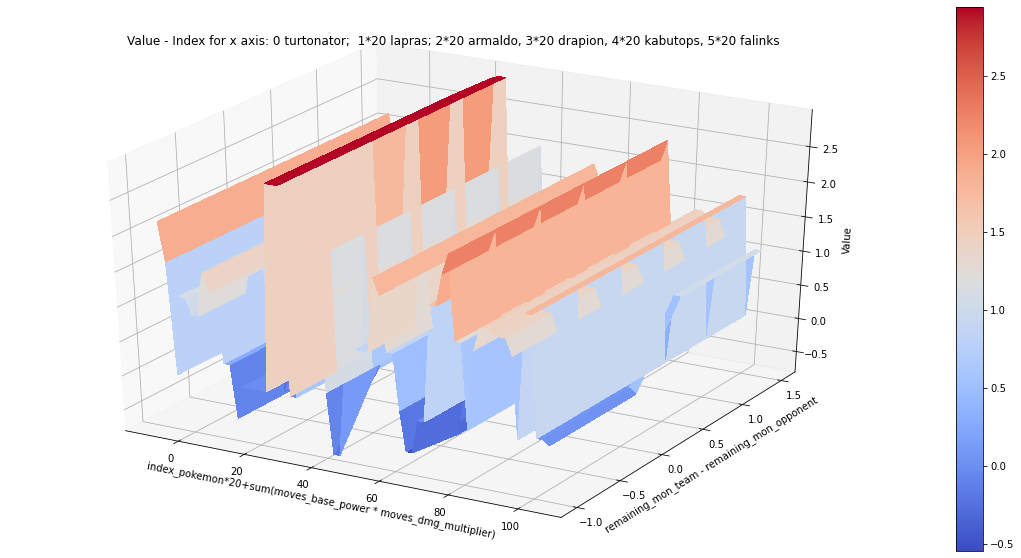

Q_MCControlDet_20211104_n_battles_10000_N0_0001_gamma_075_wining_3851


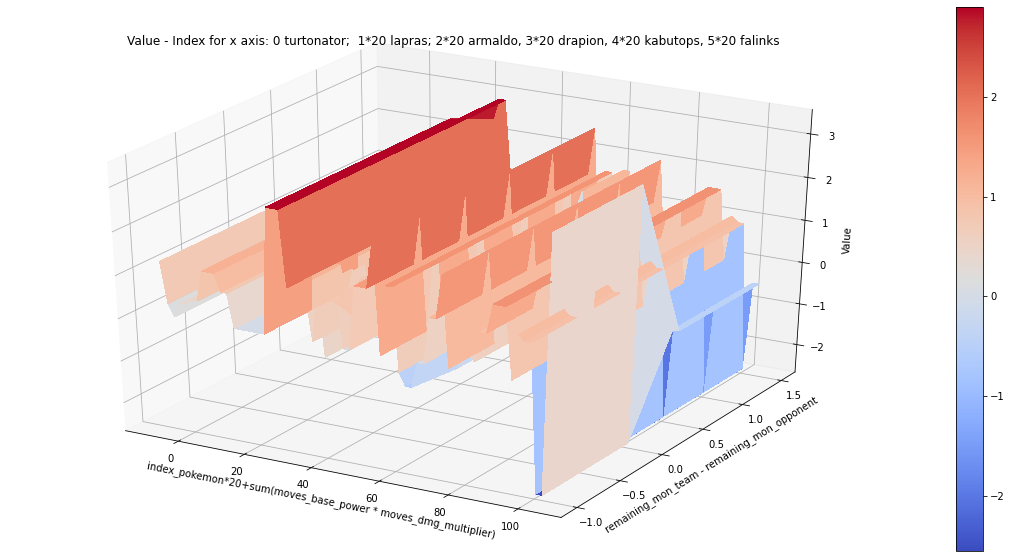

Q_MCControlDet_20211104_n_battles_10000_N0_001_gamma_075_wining_3443


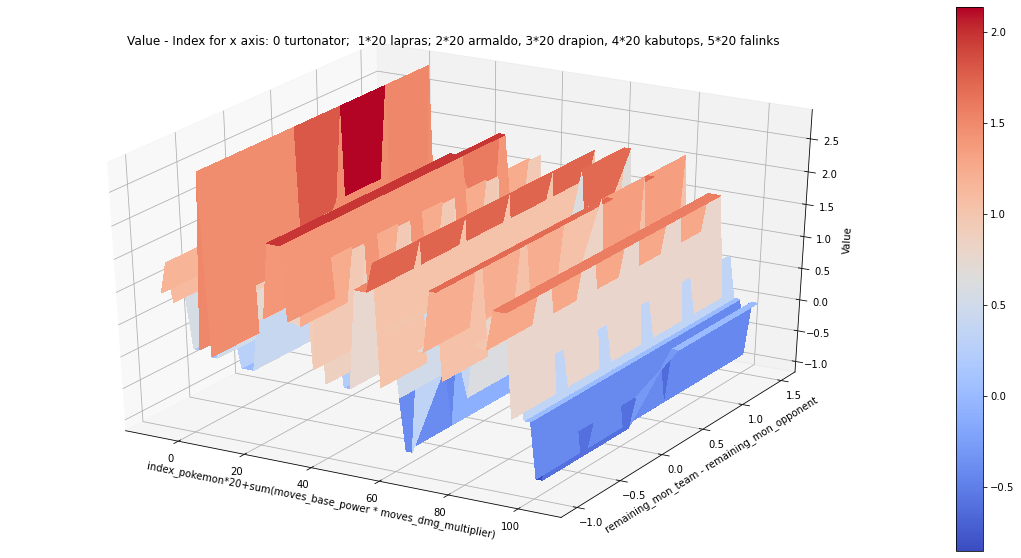

In [5]:
# x: index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)
# y: remaining_mon_team - remaining_mon_opponent
# z: value function

import pandas as pd
from scipy.interpolate import griddata
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    print(filenameQ.split('.')[0])
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('index_pokemon*20+sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value - Index for x axis: 0 turtonator;  1*20 lapras; 2*20 armaldo, 3*20 drapion, 4*20 kabutops, 5*20 falinks')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    filename = filenameQ.split('.')[0]+'_Det_Index.pdf'
    path_plot = output_folder+'/MCControl'
    if not os.path.exists(path_plot):
        os.makedirs(path_plot)
    plt.savefig(path_plot+filename) 
    plt.show()


In [14]:
# x: sum(moves_base_power * moves_dmg_multiplier)
# y: remaining_mon_team - remaining_mon_opponent
# z: value function


v_array = []
directoryQ = r'path\211104_MCControl_Det\qvalues'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []

    for state, actions in Qjson.items():    
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8]
        x_values.append(x_emb)
        y_emb = key_float[8]-key_float[9]
        y_values.append(y_emb)
        #V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))



Q_MCControlDet_20211104_n_battles_10000_N0_00001_gamma_075_wining_4039.json


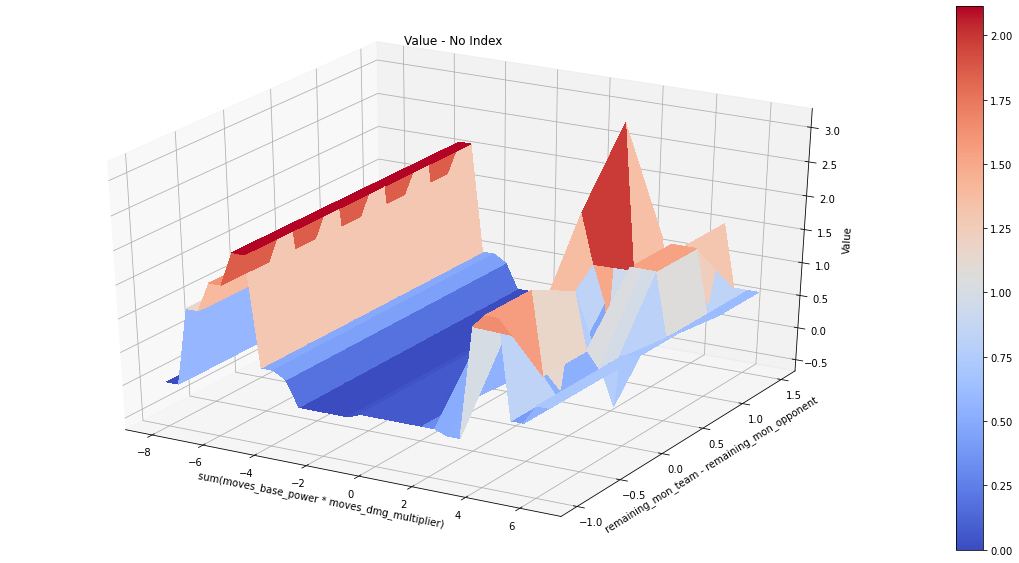

Q_MCControlDet_20211104_n_battles_10000_N0_0001_gamma_075_wining_3851.json


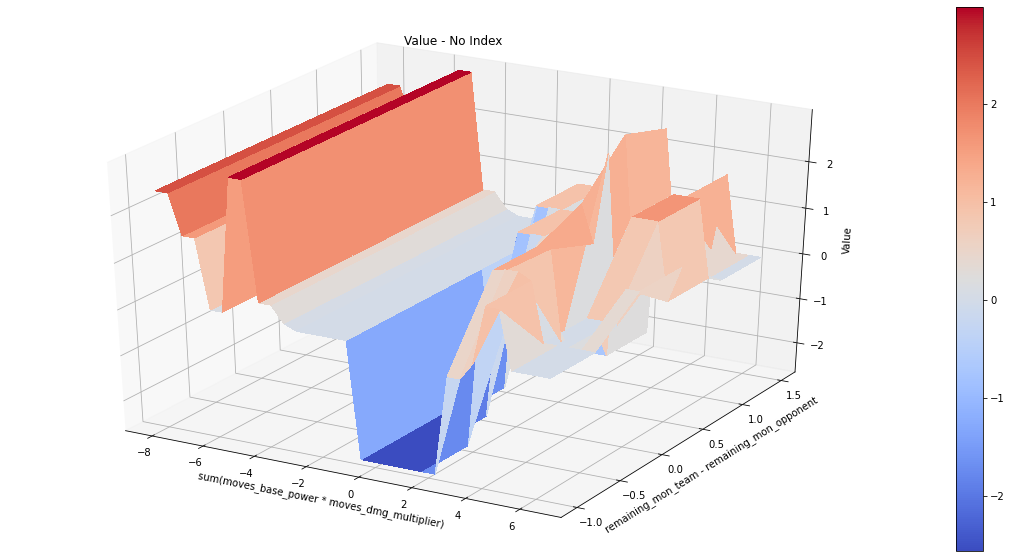

Q_MCControlDet_20211104_n_battles_10000_N0_001_gamma_075_wining_3443.json


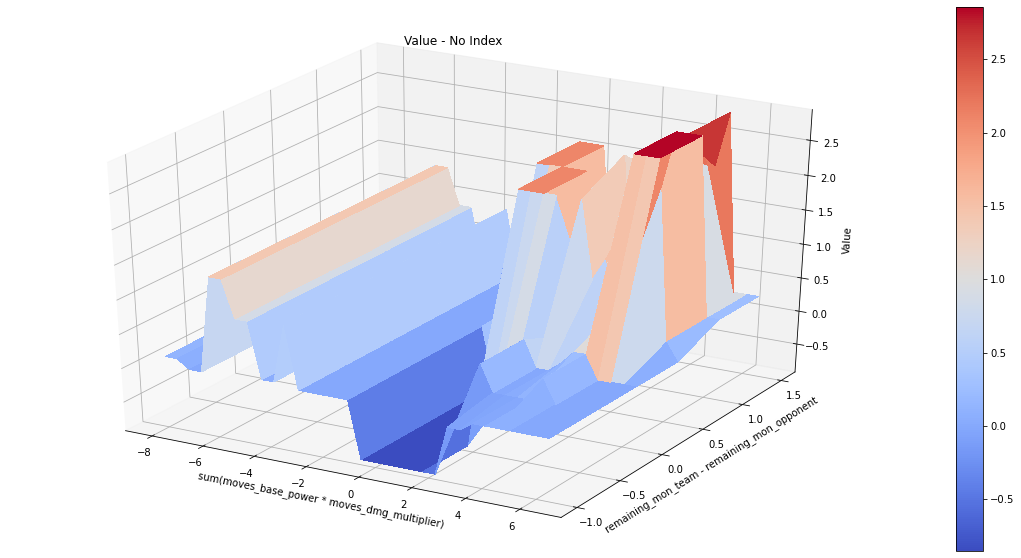

In [15]:
# x: sum(moves_base_power * moves_dmg_multiplier)
# y: remaining_mon_team - remaining_mon_opponent
# z: value function

import pandas as pd
from scipy.interpolate import griddata
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    print(filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('remaining_mon_team - remaining_mon_opponent')
    ax.set_zlabel('Value')
    ax.set_title('Value - No Index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    filename = filenameQ.split('.')[0]+'_Det_noIndex.pdf'
    path_plot = output_folder+'/MCControl'
    if not os.path.exists(path_plot):
        os.makedirs(path_plot)
    plt.savefig(path_plot+filename) 
    plt.show()

In [16]:
# x: (remaining_mon_team - remaining_mon_opponent)*sum(moves_base_power * moves_dmg_multiplier)
# y: action
# z: value function

v_array = []
directoryQ = r'path\211104_MCControl_Det\qvalues'

for filenameQ in os.listdir(directoryQ):
    Qjson_file = open(directoryQ+'/'+filenameQ,)
    Qjson = json.load(Qjson_file)

    for key in Qjson:
        Qjson[key] = np.array(Qjson[key])
        
    z_values = []
    x_values = []
    y_values = []
    for state, actions in Qjson.items(): 
        
        action_value = np.max(actions)
        z_values.append(action_value)
        state = re.sub(r"[,!?><:'\[\]()@*~#]","", state)
        key_float = [float(k) for k in state.split()]
        x_emb = (key_float[8]-key_float[9])*(key_float[1]*key_float[5]+key_float[2]*key_float[6]+key_float[3]*key_float[7]+key_float[4]*key_float[8])
        x_values.append(x_emb)
        y_emb = np.argmax(actions)
        y_values.append(y_emb)
        #V[x_emb,y_emb] = action_value
    v_array.append((x_values, y_values, z_values))

Q_MCControlDet_20211104_n_battles_10000_N0_00001_gamma_075_wining_4039.json


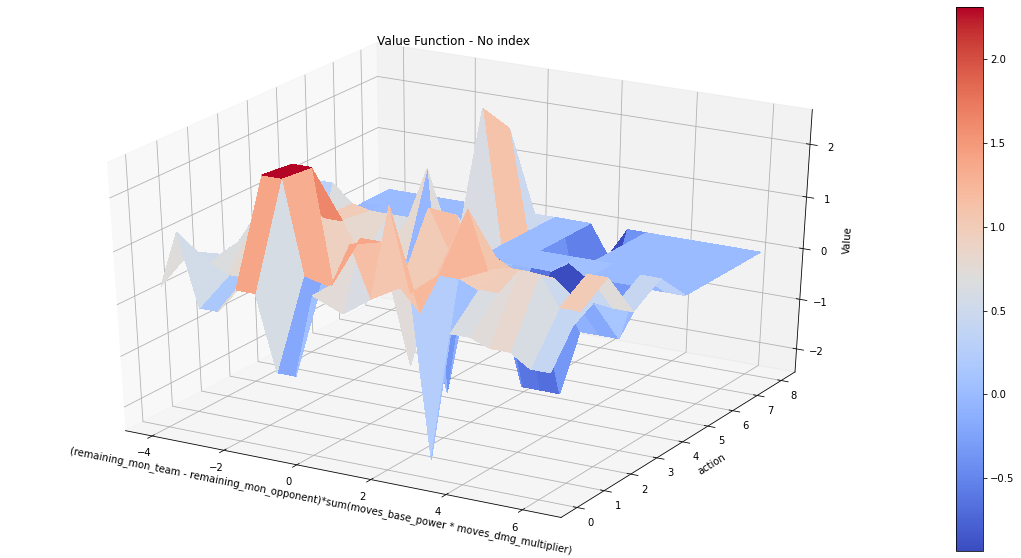

Q_MCControlDet_20211104_n_battles_10000_N0_0001_gamma_075_wining_3851.json


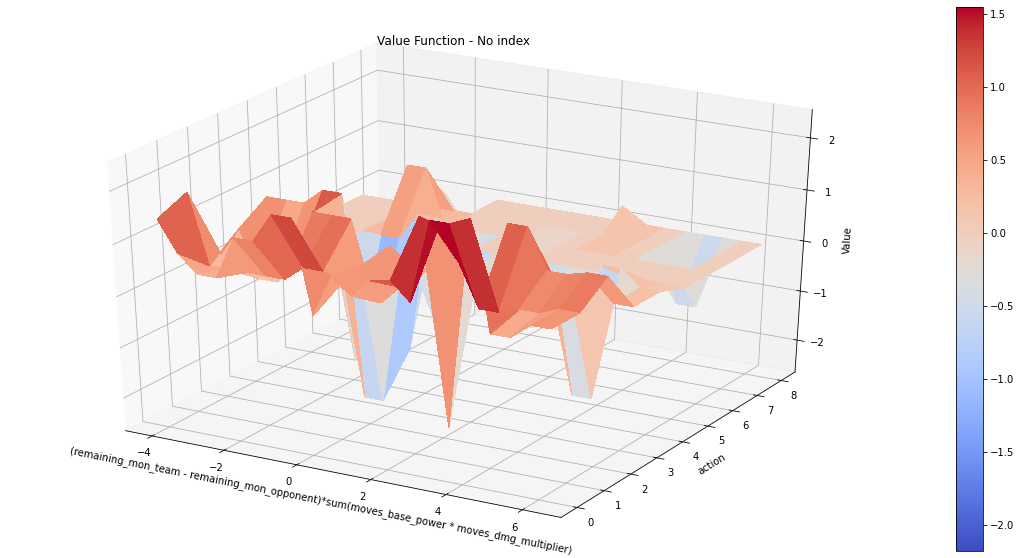

Q_MCControlDet_20211104_n_battles_10000_N0_001_gamma_075_wining_3443.json


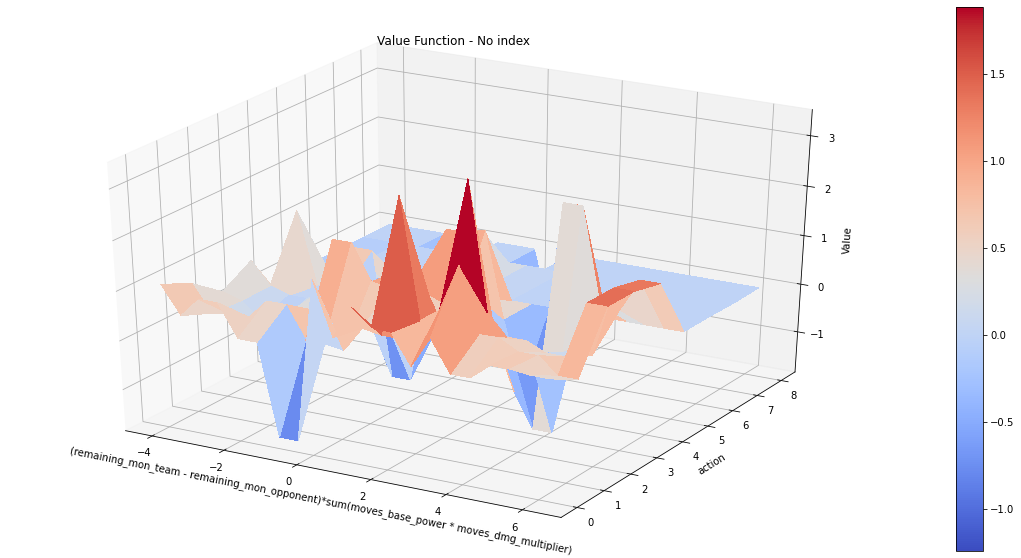

In [17]:
# x: (remaining_mon_team - remaining_mon_opponent)*sum(moves_base_power * moves_dmg_multiplier)
# y: action
# z: value function

import pandas as pd
from scipy.interpolate import griddata
for vvalue, filenameQ in zip(v_array, os.listdir(directoryQ)):
    print(filenameQ)
    x_values, y_values, z_values = vvalue 
    z_plot = np.array(z_values).reshape(len(z_values),1)
    x_plot = np.array(x_values)
    y_plot = np.array(y_values)
    xyz = {'x': x_plot, 'y': y_plot, 'z': np.array(z_values)}
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='nearest')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel('(remaining_mon_team - remaining_mon_opponent)*sum(moves_base_power * moves_dmg_multiplier)')
    ax.set_ylabel('action')
    ax.set_zlabel('Value')
    ax.set_title('Value Function - No index')

    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm,
        linewidth=0, antialiased=False)
    fig.colorbar(surf)
    filename = filenameQ.split('.')[0]+'_Det_noIndex_action.pdf'
    path_plot = output_folder+'/MCControl'
    if not os.path.exists(path_plot):
        os.makedirs(path_plot)
    plt.savefig(path_plot+filename)     
    plt.show()    